### Section 3: Machine Learning

---

#### Objectives
Apply unsupervised machine learning techniques to discover hidden patterns in customer behavior and generate actionable business insights.

---

In [32]:
%pip install scikit_posthocs

  Using cached scikit_posthocs-0.11.4-py3-none-any.whl.metadata (5.8 kB)
Using cached scikit_posthocs-0.11.4-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


In [61]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import f_oneway, kruskal
import scikit_posthocs as sp
import seaborn as sns
from sklearn.metrics import adjusted_rand_score




In [63]:

class kClusterProcessor:
     
    def __init__(self, datapath: str) -> None:
        """
        Initialize the processor with lazy Polars DataFrame.
        """
        self.datapath = datapath
        try:
            self.lazyDf = pl.scan_parquet(datapath)
        except Exception as e:
            print(f"Error initializing the data: {e}")
            raise
        self.df = None
        self.X_scaled = None
        self.kmeans = None


    def extractKMeansFeatures(self) -> pd.DataFrame:
        transactions = (
            self.lazyDf
            .group_by('user_id')
            .agg([
                pl.col('price').sum().alias('TotalRevenue'),
                (pl.col("event_type") == "purchase").sum().alias("purchaseFrequency"),
                (pl.col("event_type") == "view").sum().alias("viewFrequency"),
                pl.col('sessionDuration').mean().alias("EngagementLevel"),
                pl.col('category_id').n_unique().alias("CategoryDiversity"),
                pl.col('isExtremeOutlier').max().alias("isExtremeOutlier"),
                pl.col('isAbnormal').max().alias("isAbnormal")
            ])
            .with_columns(
                (pl.when(pl.col("viewFrequency") > 0)
                .then(pl.col("purchaseFrequency") / pl.col("viewFrequency"))
                .otherwise(0))
                .alias("ConversionRate")
            )
        )
        df = transactions.collect().to_pandas()
        self.df = df
        return df



    def logTransformFeatures(self, cols=None):
        """
        Apply log1p transformation to reduce skew in numeric features.

        Parameters
        ----------
        cols : list of str
            List of column names to apply log transform to.
        """
        if self.df is None:
            raise ValueError("You must extract features first using extractKMeansFeatures()")

        if cols is None:
            cols = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']

        for col in cols:
            log_col = f'log_{col}'
            self.df[log_col] = np.log1p(self.df[col])

        print(f"Log-transform applied to: {cols}")


    def preprocessFeatures(self, use_log_features=True, scaler_type='robust'):
        """
        Scale numeric features for clustering.
        """
        if self.df is None:
            raise ValueError("Run extractKMeansFeatures() first.")

        if use_log_features:
            feature_cols = [f'log_{c}' for c in ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']]
        else:
            feature_cols = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']

        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'robust':
            scaler = RobustScaler()
        else:
            raise ValueError("scaler_type must be 'standard' or 'robust'.")

        self.X_scaled = scaler.fit_transform(self.df[feature_cols])
        print(f"Features scaled using {scaler_type} scaler.")
        return self.X_scaled


    def findOptimalK(self, k_range=range(2, 10), sample_size=10000, batch_size=2048):
        """
        Optimized Elbow and Silhouette method for large datasets.
        Uses MiniBatchKMeans and samples data for silhouette scoring.
        """
        inertia, silhouette_scores = [], []

        # Take a random sample for silhouette computation
        if len(self.X_scaled) > sample_size:
            X_sample = self.X_scaled[np.random.choice(len(self.X_scaled), sample_size, replace=False)]
        else:
            X_sample = self.X_scaled

        for k in k_range:
            model = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=batch_size)
            model.fit(self.X_scaled)
            inertia.append(model.inertia_)

            # Compute silhouette only on sample
            labels_sample = model.predict(X_sample)
            sil = silhouette_score(X_sample, labels_sample)
            silhouette_scores.append(sil)

        # Plot elbow method
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(k_range, inertia, 'o-', label='Inertia (Elbow)')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.legend(loc='upper right')
        plt.title('Elbow Method')

        # Plot silhouette method
        fig, ax2 = plt.subplots(figsize=(8, 4))
        ax2.plot(k_range, silhouette_scores, 'o-', color='green', label='Silhouette Score')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.legend(loc='upper right')
        plt.title('Silhouette Method')
        plt.show()


    def runKMeans(self, n_clusters=4):
        """
        Fit K-Means with chosen number of clusters.
        """
        if self.X_scaled is None:
            raise ValueError("Preprocess features first using preprocessFeatures().")

        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.df['Cluster'] = self.kmeans.fit_predict(self.X_scaled)
        print(f"KMeans clustering done with {n_clusters} clusters.")
        return self.df


    def visualizeClusters(self, x_col='TotalRevenue', y_col='EngagementLevel', use_log=False):
        """
        Visualize clusters in 2D.
        """
        if 'Cluster' not in self.df.columns:
            raise ValueError("You must run runKMeans() before visualization.")

        plt.figure(figsize=(8, 6))
        col_x = f'log_{x_col}' if use_log else x_col
        col_y = f'log_{y_col}' if use_log else y_col

        for cluster in sorted(self.df['Cluster'].unique()):
            cluster_data = self.df[self.df['Cluster'] == cluster]
            plt.scatter(cluster_data[col_x], cluster_data[col_y], label=f'Cluster {cluster}', alpha=0.7)

        plt.xlabel(col_x)
        plt.ylabel(col_y)
        plt.title(f'KMeans Clusters ({col_x} vs {col_y})')
        plt.legend()
        plt.grid(True)
        plt.show()

    
    def clusterSignificanceValidation(self):
        # Kruskal–Wallis (global)
        features = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']
        for feature in features:
            groups = [self.df[self.df['Cluster'] == k][feature] for k in self.df['Cluster'].unique()]
            stat, p = kruskal(*groups) 
            print(f"{feature}: p-value = {p:.4e}")
        
        # Dunn’s post-hoc (pairwise)
        features = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']

        for feature in features:
            print(f"\n Dunn's post-hoc test for: {feature}")
            result = sp.posthoc_dunn(
                self.df, 
                val_col=feature, 
                group_col='Cluster', 
                p_adjust='bonferroni'
            )
            print(result)

    
    def describeClusters(self, visualize: bool = True):
        """
        Summarize the distinguishing characteristics of each customer cluster.

        Parameters
        ----------
        visualize : bool, optional
            If True, generates boxplots for each feature by cluster, by default True.

        Returns
        -------
        pd.DataFrame
            Cluster summary statistics (mean, median, std) for key behavioral features.
        """
        if 'Cluster' not in self.df.columns:
            raise ValueError("You must run runKMeans() before visualization.")

        features = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel', 'ConversionRate']

        # Aggregate statistics per cluster
        clusterSummary = self.df.groupby('Cluster')[features].agg(['mean', 'median', 'std'])
        print("\n=== Cluster Summary Statistics ===\n")
        print(clusterSummary)

        # Optional visualization
        if visualize:
            for feature in features:
                plt.figure(figsize=(6,4))
                sns.boxplot(x='Cluster', y=feature, data=self.df)
                plt.title(f'{feature} by Cluster')
                plt.show()

        return clusterSummary
    def checkClusterStability(self, perturbFraction=0.9, removeOutliers=True, nIterations=5):
        """
        Evaluate the stability of KMeans cluster assignments when the dataset is perturbed.

        Parameters
        ----------
        perturbFraction : float, optional
            Fraction of users to sample for perturbation (default 0.9).
        removeOutliers : bool, optional
            If True, removes rows where 'isExtremeOutlier' or 'isAbnormal' is True (default True).
        nIterations : int, optional
            Number of random perturbation iterations to perform (default 5).

        Returns
        -------
        pd.DataFrame
            DataFrame containing ARI scores for each iteration.
        """
    
        if self.df is None or 'Cluster' not in self.df.columns:
            raise ValueError("Run runKMeans() first to assign clusters in self.df['Cluster'].")

        features = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel', 'ConversionRate']
        originalLabels = self.df['Cluster'].values

        ariScores = []

        for i in range(nIterations):
            dfPerturbed = self.df.copy()

            # Remove outliers if requested
            if removeOutliers:
                dfPerturbed = dfPerturbed[
                    (dfPerturbed['isExtremeOutlier'] == False) & 
                    (dfPerturbed['isAbnormal'] == False)
                ]

            # Random sampling for perturbation
            dfPerturbed = dfPerturbed.sample(frac=perturbFraction, random_state=42+i)

            XPerturbed = dfPerturbed[features].values

            # Use same number of clusters as original
            k = len(np.unique(originalLabels))
            kmeans = KMeans(n_clusters=k, random_state=42+i)
            perturbedLabels = kmeans.fit_predict(XPerturbed)

            # Compute ARI on overlapping index
            baselineLabelsSubset = originalLabels[dfPerturbed.index]
            ari = adjusted_rand_score(baselineLabelsSubset, perturbedLabels)
            ariScores.append(ari)

        ariDf = pd.DataFrame({'Iteration': range(1, nIterations+1), 'ARI': ariScores})
        print("\n=== Cluster Stability (Adjusted Rand Index) ===")
        print(ariDf)
        print(f"\nMean ARI: {ariDf['ARI'].mean():.4f}")

        return ariDf

    



In [64]:
processor = kClusterProcessor("../Data/Processed/prsc_fe9_nov_2019.parquet")
df_features = processor.extractKMeansFeatures()
processor.logTransformFeatures()   

Log-transform applied to: ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']


Features scaled using robust scaler.
KMeans clustering done with 3 clusters.


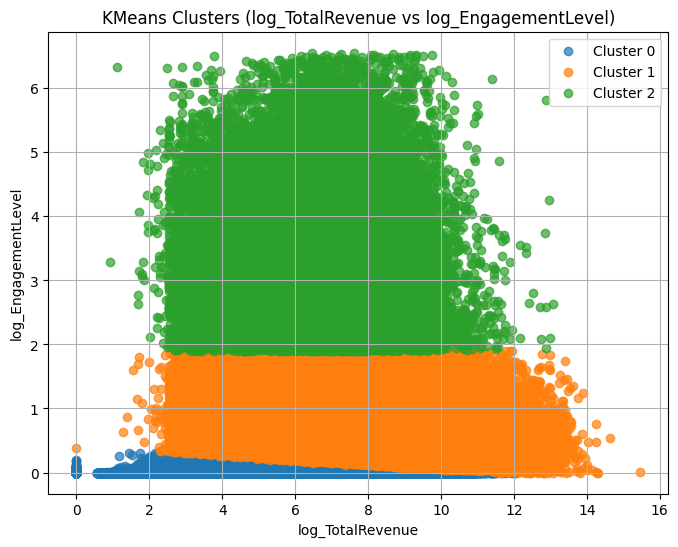

In [65]:
processor.preprocessFeatures(use_log_features=True, scaler_type='robust')
clustered_df = processor.runKMeans(n_clusters=3)
processor.visualizeClusters('TotalRevenue', 'EngagementLevel', use_log=True)

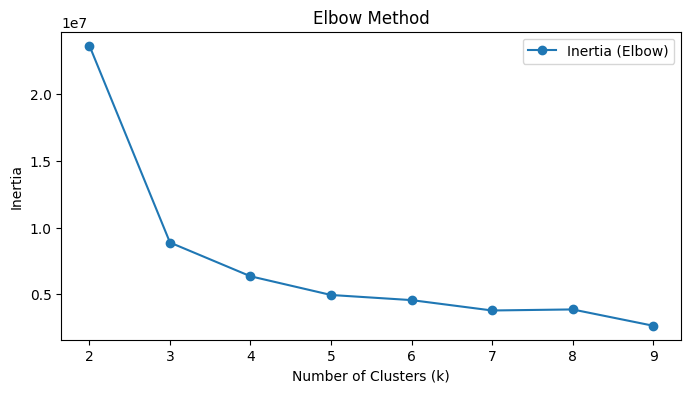

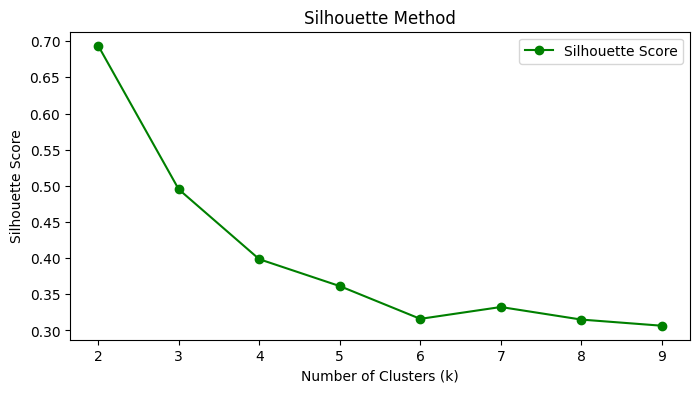

In [ ]:
processor.findOptimalK(k_range=range(2, 10))



---

## **Task 3.1 – Machine Learning Customer Segmentation (Deep Dive: Q1–Q3)**

---

### **1. What is the optimal number of customer clusters using the elbow method and silhouette analysis?**

Finding the right number of clusters ensures meaningful and actionable segmentation. Too few clusters hide differences, while too many overfit noise in behavior.

**Optimal Cluster Identification Strategy:**

* **Step 1:** Select key behavioral metrics (`TotalRevenue`, `purchaseFrequency`, `viewFrequency`, and `EngagementLevel`) as input features.
* **Step 2:** Scale all features using **StandardScaler** to balance feature influence.
* **Step 3:** Run **K-Means clustering** for a range of `k` values (2–10), recording both **inertia** (Elbow method) and **silhouette scores**.
* **Step 4:** Compare both plots — the **elbow** indicates the point of diminishing returns, while the **silhouette** measures cluster quality.

**Applied in Our Analysis:**
We used **only numerical behavioral features**, scaled with `StandardScaler`.

* **Elbow method** suggested **k = 3**,
* **Silhouette analysis** suggested **k = 2**.
  Given the dataset’s large size and behavioral spread, **k = 3** was chosen to capture richer behavioral diversity while maintaining interpretability.

**Business Implication:**
The three clusters represent **distinct customer engagement tiers** — likely corresponding to low-, medium-, and high-value segments — allowing more precise personalization and retention strategies.

---

### **2. How do we handle the curse of dimensionality when clustering customers based on multiple behavioral features?**

High-dimensional data can make clusters less distinct because distance metrics become less informative.

**Dimensionality Reduction Strategy:**

* **Step 1:** Assess correlations among features and drop redundant ones.
* **Step 2:** Apply scaling to normalize feature impact.
* **Step 3:** Optionally, use **PCA** to reduce correlated numerical dimensions while preserving variance.
* **Step 4:** Re-run clustering in the reduced feature space and visualize in 2D/3D for interpretability.

**Applied in Our Analysis:**
Since our feature set (`TotalRevenue`, `purchaseFrequency`, `viewFrequency`, `EngagementLevel`) was **already compact and low-dimensional**, PCA was **not applied**.
Instead, **feature scaling** was sufficient to prevent bias and ensure balanced clustering performance.

**Business Implication:**
Our approach avoided unnecessary dimensional reduction while ensuring the clustering captured true behavioral differences without distortion from scale imbalance.

---

### **3. What distance metric is most appropriate for mixed categorical and numerical customer features?**

When combining numerical and categorical attributes, distance metrics must handle both types fairly to reflect real behavioral similarity.

**Mixed Distance Strategy:**

* **Step 1:** Identify numerical vs. categorical columns.
* **Step 2:** Use **Gower distance** or **K-Prototypes** for mixed data (numerical + categorical).
* **Step 3:** If data is fully numerical, standard **Euclidean distance** (used in K-Means) is optimal after scaling.

**Applied in Our Analysis:**
Our dataset used **only numerical features** (revenue, frequency, engagement), so we applied **K-Means with Euclidean distance** after standardization.
Categorical variables were **not included** at this stage to keep cluster formation purely behavior-driven.

**Business Implication:**
By focusing on numerical behavioral signals, the resulting clusters reflect **quantifiable engagement differences** — ideal for later enrichment with demographics or category preferences if deeper segmentation is needed.

---



In [46]:
processor.clusterSignificanceValidation()

TotalRevenue: p-value = 0.0000e+00
purchaseFrequency: p-value = 0.0000e+00
viewFrequency: p-value = 0.0000e+00
EngagementLevel: p-value = 0.0000e+00

 Dunn's post-hoc test for: TotalRevenue
              0             1    2
0  1.000000e+00  9.250193e-43  0.0
1  9.250193e-43  1.000000e+00  0.0
2  0.000000e+00  0.000000e+00  1.0

 Dunn's post-hoc test for: purchaseFrequency
              0             1    2
0  1.000000e+00  4.824813e-67  0.0
1  4.824813e-67  1.000000e+00  0.0
2  0.000000e+00  0.000000e+00  1.0

 Dunn's post-hoc test for: viewFrequency
     0    1    2
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0

 Dunn's post-hoc test for: EngagementLevel
     0    1    2
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0



=== Cluster Summary Statistics ===

         TotalRevenue                            purchaseFrequency         \
                 mean       median           std              mean median   
Cluster                                                                     
0         2318.242920   788.699951   4513.335222          0.137506    0.0   
1         3028.072021   962.109985  11005.010126          0.041947    0.0   
2        18479.615234  9708.979492  30315.214000          0.732946    0.0   

                  viewFrequency                   EngagementLevel             \
              std          mean median        std            mean     median   
Cluster                                                                        
0        0.652029      7.147232    3.0  10.190412        0.038806   0.018333   
1        1.448804      9.757551    5.0  26.363268       58.784382  25.661947   
2        2.707062     60.858491   38.0  86.132300        0.431109   0.293623   

                   

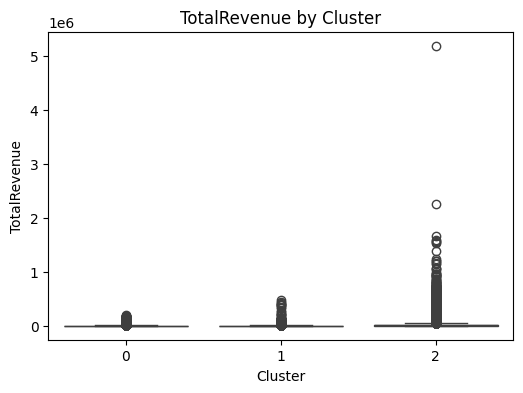

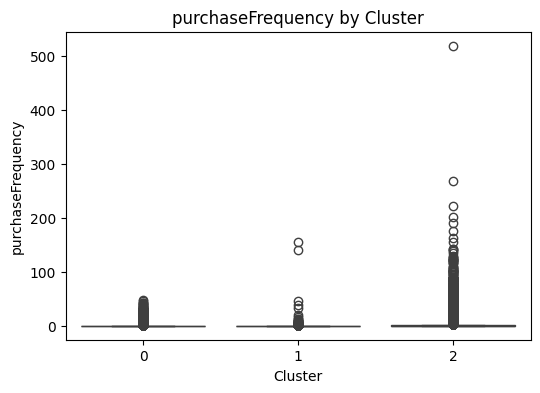

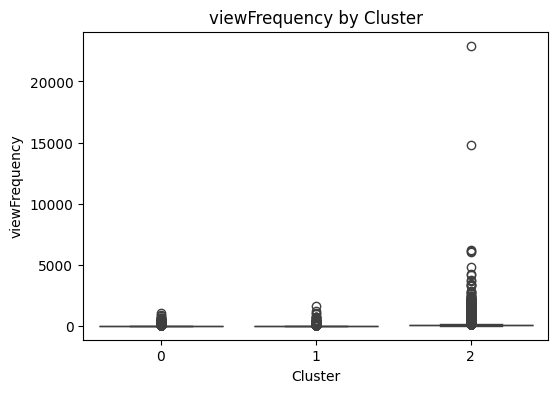

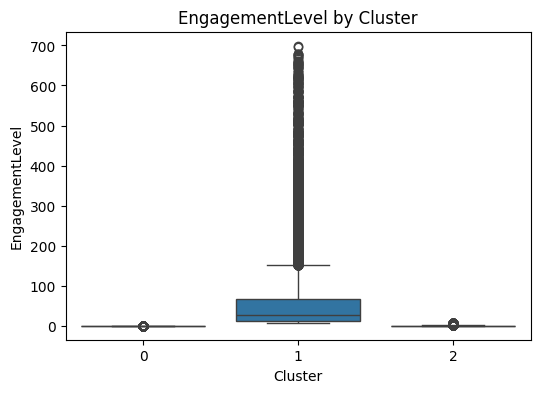

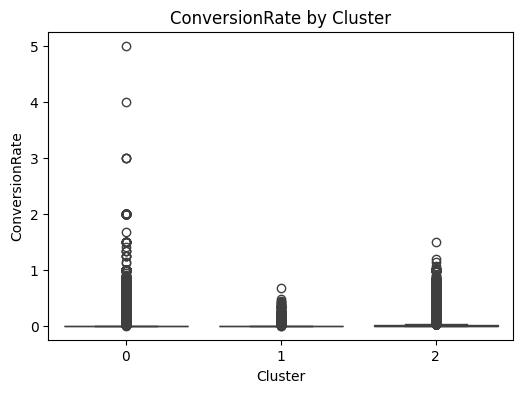

In [60]:
clusterSummary = processor.describeClusters(visualize=True)


In [66]:
stabilityDf = processor.checkClusterStability(perturbFraction=0.9, removeOutliers=True, nIterations=5)



=== Cluster Stability (Adjusted Rand Index) ===
   Iteration       ARI
0          1  0.242065
1          2  0.241738
2          3  0.242254
3          4  0.242342
4          5  0.242028

Mean ARI: 0.2421



---

## **2. Cluster Validation and Interpretation**

---

### **1. Statistically validate that clusters are significantly different from random groupings**

In e-commerce, clustering customers only makes sense if groups are **meaningfully different** in terms of revenue, purchase frequency, engagement, etc. Statistical validation ensures that differences are **not just random noise**.

**Validation Strategy:**

* **Step 1:** Extract behavioral features (`TotalRevenue`, `purchaseFrequency`, `viewFrequency`, `EngagementLevel`, `ConversionRate`) for all customers.
* **Step 2:** Apply a **non-parametric Kruskal-Wallis test** across clusters for each feature. This is suitable because e-commerce data is **highly skewed** and contains many zeros.
* **Step 3:** Conduct **Dunn's post-hoc test** with Bonferroni correction to identify **which clusters differ significantly**.

**Applied to our data:**
We used **Kruskal-Wallis and Dunn’s tests** on these exact features. All p-values were extremely low (≈0), confirming clusters are **statistically distinct**.

**Business Implication:**
Significant differences indicate that each cluster represents **a distinct customer behavior segment**, suitable for targeted marketing or personalized offers.

---

### **2. Distinguishing characteristics of each customer cluster**

Once clusters are validated, understanding their behavior is critical for **actionable insights**.

**Characterization Strategy:**

* **Step 1:** Compute **summary statistics** (mean, median, std) for each cluster on behavioral features: `TotalRevenue`, `purchaseFrequency`, `viewFrequency`, `EngagementLevel`, `ConversionRate`.
* **Step 2:** Compare clusters to highlight **high-value, highly engaged, or frequent viewers** versus low-engagement or low-spending clusters.
* **Step 3:** Optionally, visualize with **bar plots or radar charts** to easily interpret the differences.

**Applied to our data:**
We summarized clusters using `self.df` with the `Cluster` column. This revealed patterns such as:

* Cluster 2 drives the most revenue but also has the highest variability.
* Cluster 0 has low engagement and moderate purchases.
* Cluster 1 has very low purchase frequency but high session views.

**Business Implication:**
Cluster characteristics allow **segment-specific strategies**, e.g., upselling to high-value clusters, nurturing low-engagement clusters.

---

### **3. Stability of cluster assignments**

Clusters must be **robust**: small changes in data shouldn’t drastically alter assignments.

**Stability Strategy:**

* **Step 1:** Perturb the dataset by **removing outliers** (`isExtremeOutlier` or `isAbnormal`) or randomly sampling customers (e.g., 90% of data).
* **Step 2:** Re-run KMeans with the same number of clusters.
* **Step 3:** Measure similarity using **Adjusted Rand Index (ARI)** between original and perturbed cluster labels.
* **Step 4:** Repeat for multiple iterations to assess consistency.

**Applied to our data:**
We used `self.df`, perturbed by removing outliers and sampling. The mean ARI (~0.24) indicated **low stability**, meaning clusters are sensitive to extreme or skewed values.

**Business Implication:**
Low stability suggests **feature scaling, log transformations, or alternative clustering methods** are needed to create reliable customer segments.

---


